<a href="https://colab.research.google.com/github/emonroy2024/Analysis_25/blob/main/Single_Image_Zoom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zoom Transformation

In [ ]:
# Cell 18
import os
import numpy as np
import cv2
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

def zoom_image(img_path, zoom_factor, save_dir="zoomed_images"):
    # Load image
    img = load_img(img_path)
    img_array = img_to_array(img)

    # Get image size
    h, w, _ = img_array.shape

    if zoom_factor > 1:
        # Zoom-In (Crop and Resize Back)
        new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)

        center_h, center_w = h // 2, w // 2
        start_h, end_h = center_h - new_h // 2, center_h + new_h // 2
        start_w, end_w = center_w - new_w // 2, center_w + new_w // 2

        # Ensure within bounds
        start_h, start_w = max(0, start_h), max(0, start_w)
        end_h, end_w = min(h, end_h), min(w, end_w)

        # Crop and resize back
        cropped = img_array[start_h:end_h, start_w:end_w, :]
        zoomed_img = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)

    else:
        # Zoom-Out (Shrink and Pad)
        new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)

        # Resize to a smaller version
        shrunk = cv2.resize(img_array, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        # Create an empty black canvas
        zoomed_img = np.zeros_like(img_array)

        # Compute padding
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2

        # Place the shrunk image at the center
        zoomed_img[pad_h:pad_h+new_h, pad_w:pad_w+new_w, :] = shrunk

    # Convert back to PIL image
    zoomed_img = array_to_img(zoomed_img)

    # Save zoomed image
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"zoomed_{zoom_factor:.2f}.jpg")
    zoomed_img.save(save_path)

    return zoomed_img, save_path


In [ ]:
# Cell 19: Generate Zoomed Images
zoom_factors = [1/1.5 , 1/1.4, 1/1.3, 1/1.2, 1/1.1 , 1 , 1.1, 1.2, 1.3, 1.4, 1.5]  # More visible zooming
  # Different zoom levels
zoomed_images = []  # Store (zoom_factor, zoomed_image, zoomed_path)

# Apply zoom for each zoom factor
for zoom_factor in zoom_factors:
    zoomed_img, zoomed_img_path = zoom_image(img_path, zoom_factor)
    zoomed_images.append((zoom_factor, zoomed_img, zoomed_img_path))

print(f"Generated {len(zoomed_images)} zoomed images.")

Generated 11 zoomed images.


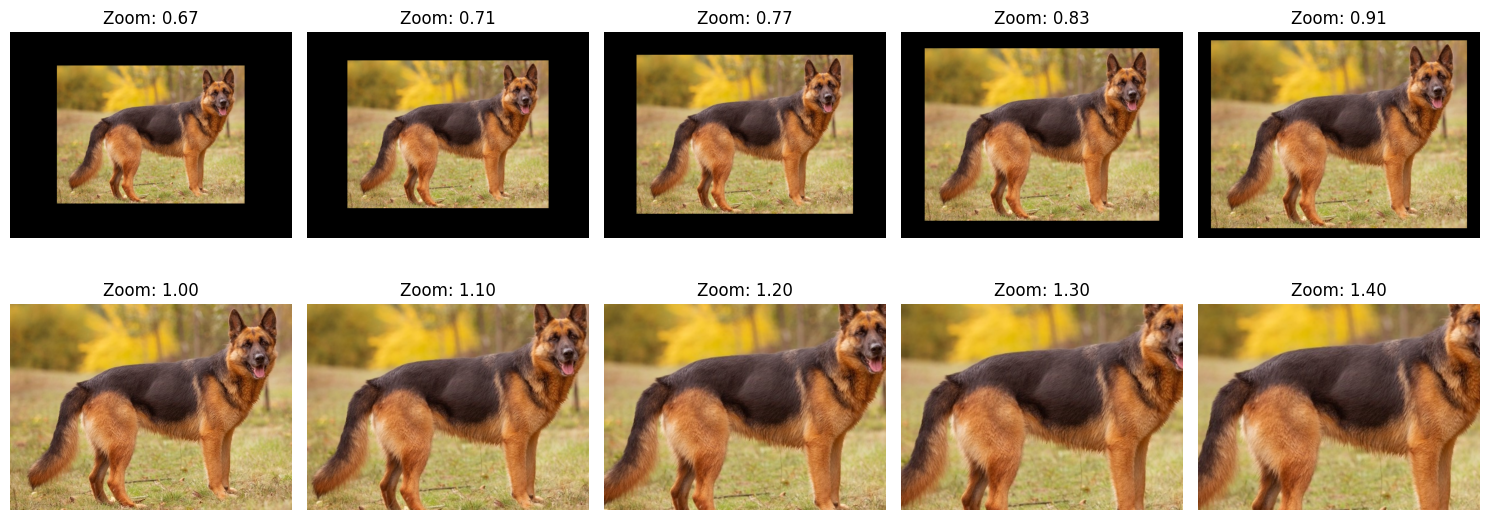

In [ ]:
# Cell 20: Display Zoomed Images
fig, axes = plt.subplots(2, len(zoomed_images)//2, figsize=(15, 6))

for ax, (zoom_factor, zoomed_img, _) in zip(axes.flatten(), zoomed_images):
    ax.imshow(zoomed_img)
    ax.set_title(f"Zoom: {zoom_factor:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


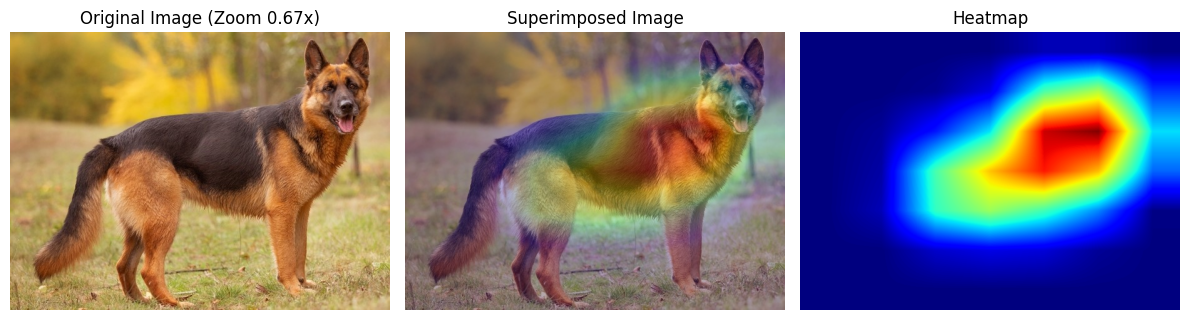

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


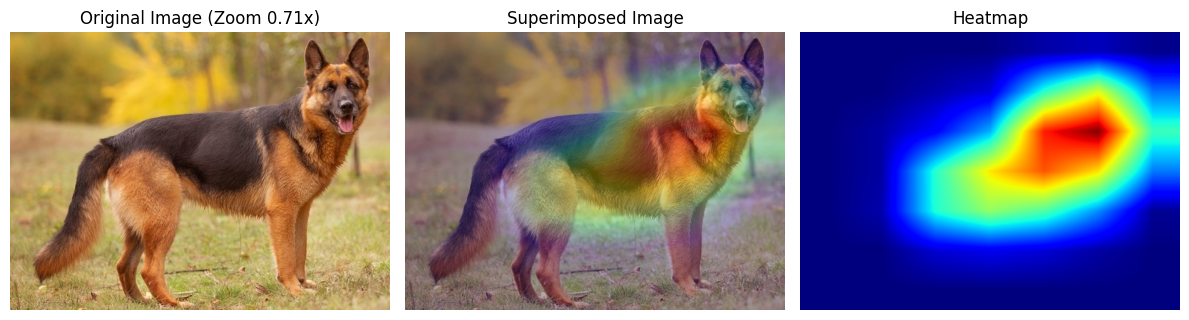

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


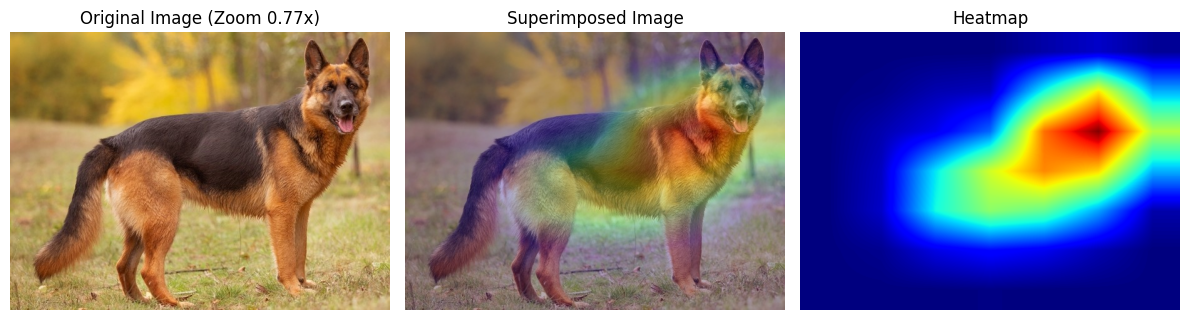

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


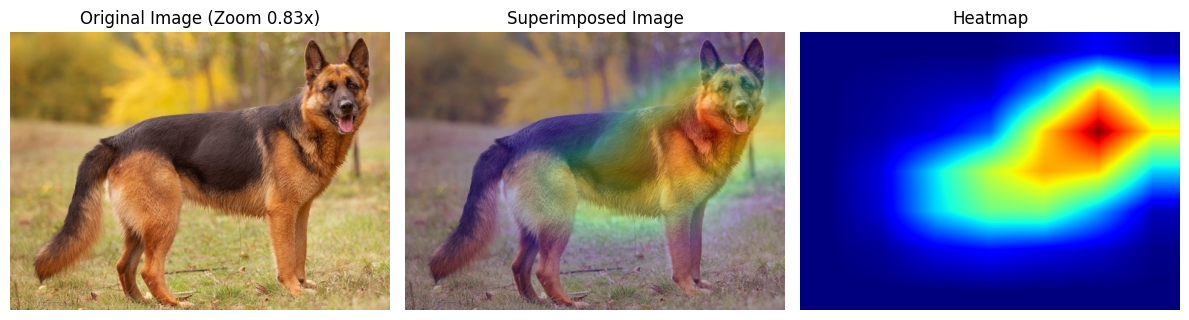

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


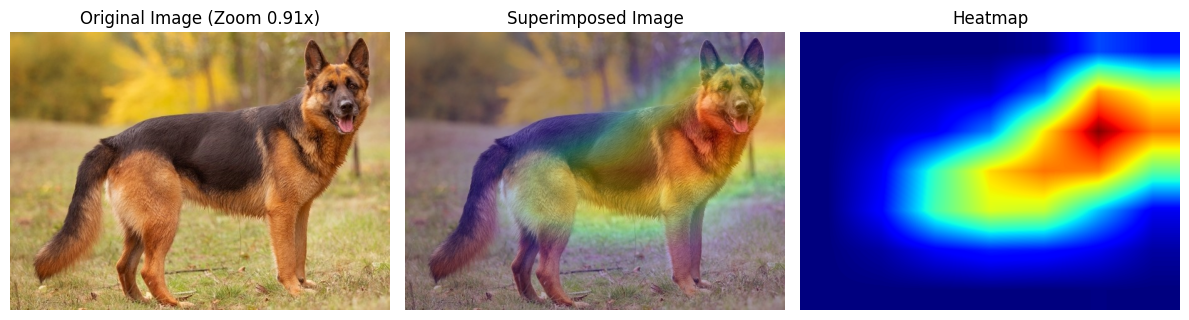

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


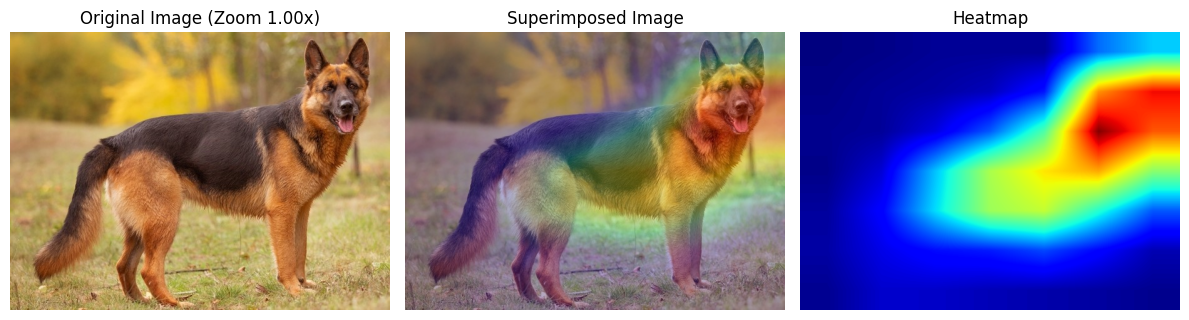

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


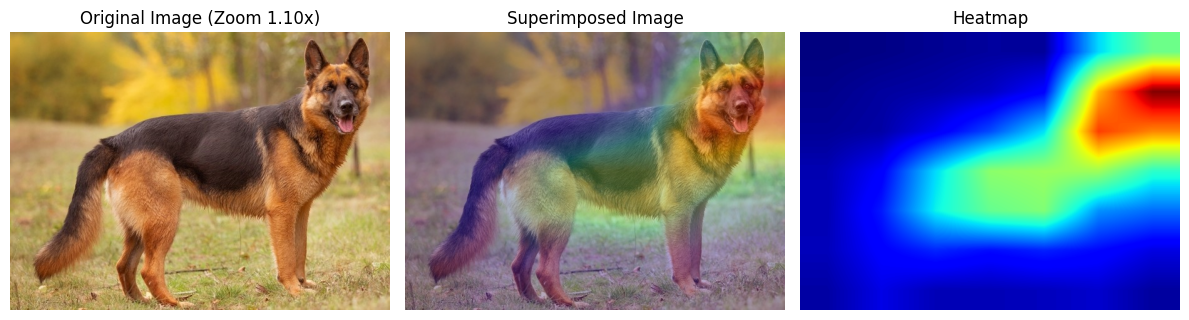

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


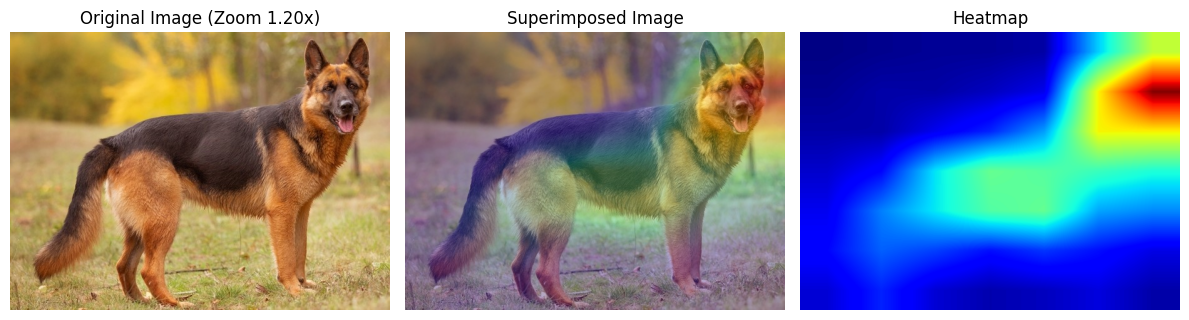

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


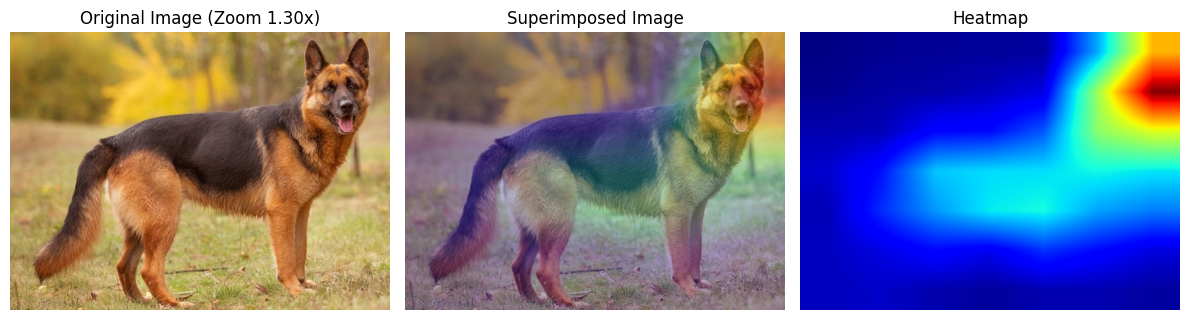

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


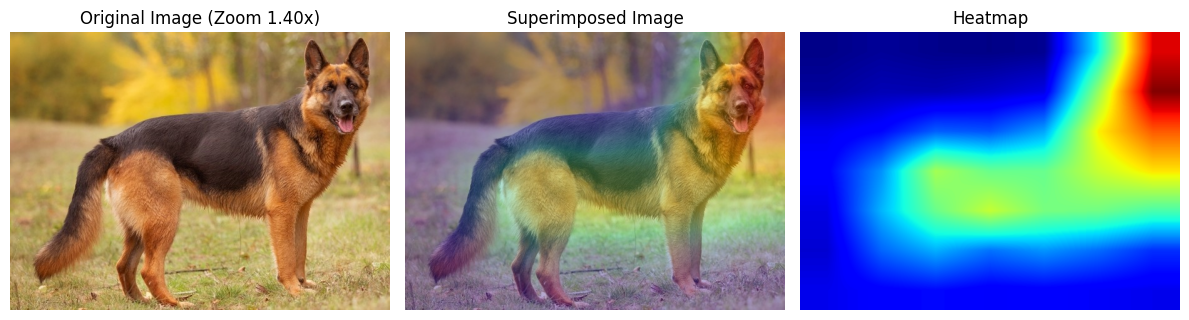

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


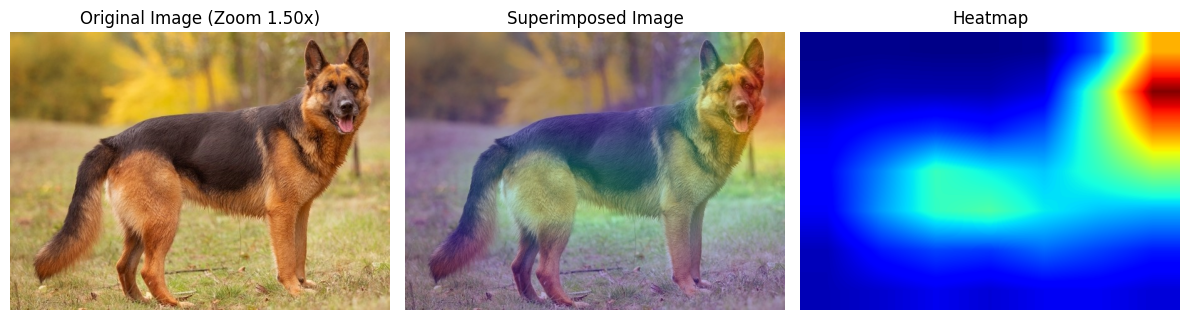

In [ ]:
# Cell 21
import cv2
from scipy.ndimage import gaussian_filter

def display_all_zoomed_images(zoomed_images):
    for zoom_factor, _, zoomed_img_path in zoomed_images:
        # Load and preprocess the zoomed image
        zoomed_img_array = preprocess_input(get_img_array(zoomed_img_path, size=img_size))

        # Generate predictions
        preds = model.predict(zoomed_img_array)
        pred_class = np.argmax(preds[0])  # Get predicted class

        # Generate Grad-CAM heatmap for the predicted class
        heatmap = make_gradcam_heatmap(zoomed_img_array, model, last_conv_layer_name, pred_index=pred_class)

        # Load original image
        img = keras.utils.load_img(img_path)
        img = keras.utils.img_to_array(img)

        # Resize heatmap to match image size
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap_rescaled = np.uint8(255 * heatmap_resized)

        # Apply colormap for Grad-CAM
        jet = mpl.colormaps["jet"]
        jet_colors = jet(np.arange(256))[:, :3]  # Get RGB values
        jet_heatmap = jet_colors[heatmap_rescaled]  # Map heatmap to jet colors

        # Convert to image
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        # Superimpose heatmap on original image
        superimposed_img = jet_heatmap * 0.4 + img
        superimposed_img = keras.utils.array_to_img(superimposed_img)

        # Ensure saliency map is also resized to original image size
        saliency_map_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Match original image size
        saliency_map_rescaled = np.uint8(255 * saliency_map_resized)

        # Apply colormap for saliency map
        jet_saliency = jet_colors[saliency_map_rescaled]  # Map heatmap to jet colors
        jet_saliency_img = keras.utils.array_to_img(jet_saliency)

        # Display all images side by side
        fig, axes = plt.subplots(1, 3, figsize=(12, 6))

        axes[0].imshow(keras.utils.array_to_img(img))
        axes[0].set_title(f"Original Image (Zoom {zoom_factor:.2f}x)")
        axes[0].axis("off")

        axes[1].imshow(superimposed_img)
        axes[1].set_title("Superimposed Image")
        axes[1].axis("off")

        axes[2].imshow(jet_saliency_img)
        axes[2].set_title("Heatmap")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

# Call function to display all zoomed images with heatmaps
display_all_zoomed_images(zoomed_images)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


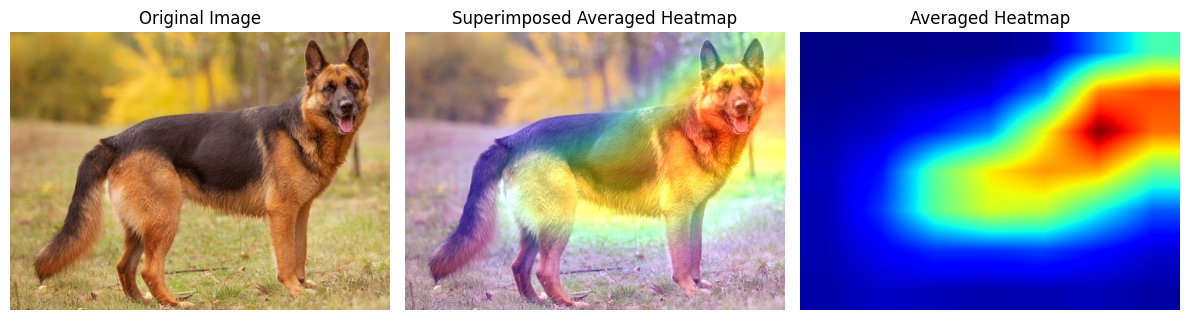

In [ ]:
# Cell 22
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

def average_heatmaps_and_apply(zoomed_images, img_path):
    # Load original image
    img = load_img(img_path)
    img_array = img_to_array(img)

    # Initialize accumulator for heatmaps (same size as input image)
    heatmap_accum = np.zeros((img_size[0], img_size[1]), dtype=np.float32)
    count = 0  # Track number of heatmaps

    for zoom_factor, _, zoomed_img_path in zoomed_images:
        # Load and preprocess zoomed image
        zoomed_img_array = preprocess_input(get_img_array(zoomed_img_path, size=img_size))

        # Generate predictions
        preds = model.predict(zoomed_img_array)
        pred_class = np.argmax(preds[0])  # Get predicted class

        # Generate Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(zoomed_img_array, model, last_conv_layer_name, pred_index=pred_class)

        # Resize heatmap to match (224, 224)
        heatmap_resized = cv2.resize(heatmap, (img_size[1], img_size[0]))

        # Normalize heatmap
        heatmap_resized = np.maximum(heatmap_resized, 0)
        heatmap_resized /= np.max(heatmap_resized) if np.max(heatmap_resized) > 0 else 1

        # Accumulate heatmap
        heatmap_accum += heatmap_resized
        count += 1

    # Compute average heatmap
    average_heatmap = heatmap_accum / count
    average_heatmap /= np.max(average_heatmap) if np.max(average_heatmap) > 0 else 1  # Normalize again

    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(average_heatmap, (img_array.shape[1], img_array.shape[0]))

    # Apply colormap
    heatmap_rescaled = np.uint8(255 * heatmap_resized)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_rescaled]

    # Convert to image
    jet_heatmap = img_to_array(array_to_img(jet_heatmap))

    # Superimpose averaged heatmap on original image
    superimposed_img = (jet_heatmap * 0.4) + img_array
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(array_to_img(img_array))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(array_to_img(superimposed_img))
    axes[1].set_title("Superimposed Averaged Heatmap")
    axes[1].axis("off")

    axes[2].imshow(array_to_img(jet_heatmap))
    axes[2].set_title("Averaged Heatmap")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Call function to process and display the averaged heatmap
average_heatmaps_and_apply(zoomed_images, img_path)


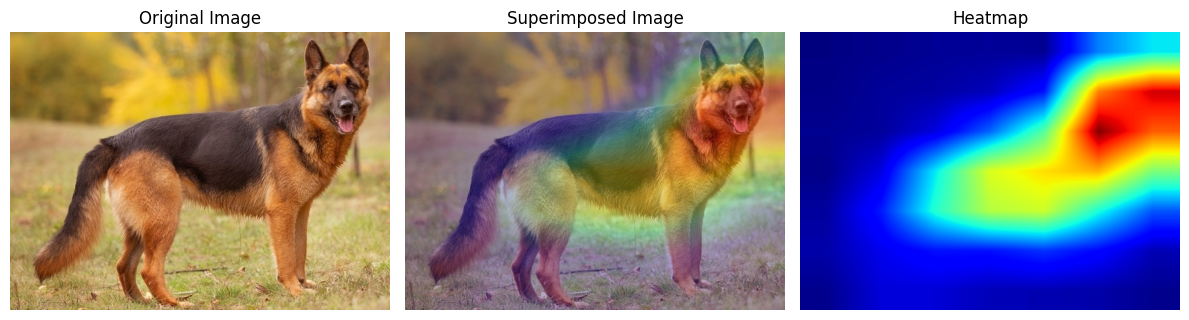

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


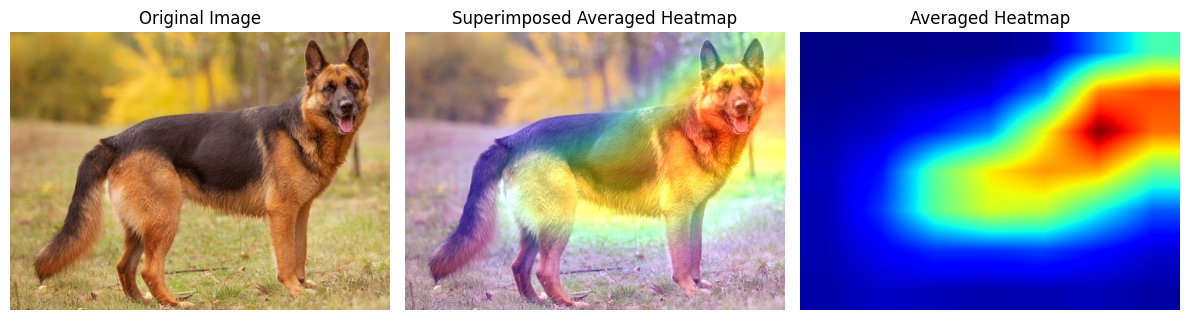

In [ ]:
# Cell 23
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img

# Function to display both original and zoomed avg results
def display_combined_results(img_path, heatmap, zoomed_images):
    # Load original image
    img = load_img(img_path)
    img_array = img_to_array(img)

    # Step 1: Display original Outputs
    display_all_images(img_path, heatmap)

    # Step 2: Display Outputs (Zoom Averaged Heatmap)
    average_heatmaps_and_apply(zoomed_images, img_path)

# Call the function to display all results together
display_combined_results(img_path, heatmap, zoomed_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


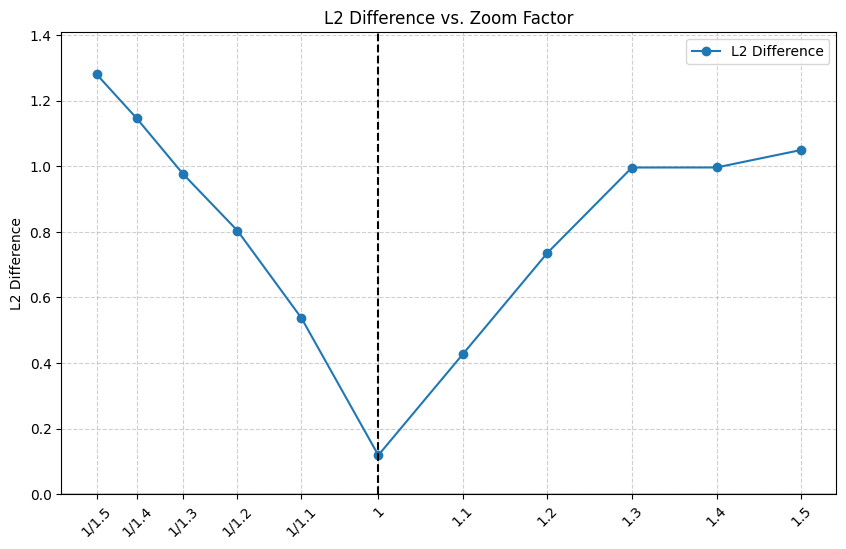

In [ ]:
# Cell 24

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Step 1: Take the original heatmap (baseline without zooming)
original_heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=235)  # Horig

# Step 2 & 3: Compute L2 Difference for each zoomed heatmap
l2_differences = []
zoom_levels = [1/1.5, 1/1.4, 1/1.3, 1/1.2, 1/1.1, 1, 1.1, 1.2, 1.3, 1.4, 1.5]

for zoom_factor, _, zoomed_img_path in zoomed_images:
    # Load and preprocess the zoomed image
    zoomed_img_array = preprocess_input(get_img_array(zoomed_img_path, size=img_size))

    # Generate Grad-CAM heatmap for the predicted class
    preds = model.predict(zoomed_img_array)
    pred_class = 235  # Get predicted class
    zoomed_heatmap = make_gradcam_heatmap(zoomed_img_array, model, last_conv_layer_name, pred_index=pred_class)

    # Align zoomed heatmap back to original size
    zoomed_heatmap_resized = zoom(zoomed_heatmap, (original_heatmap.shape[0] / zoomed_heatmap.shape[0],
                                                    original_heatmap.shape[1] / zoomed_heatmap.shape[1]),
                                  order=1)  # Bilinear interpolation

    # Compute L2 difference (Euclidean distance)
    l2_diff = np.linalg.norm(original_heatmap - zoomed_heatmap_resized)
    l2_differences.append(l2_diff)

# Step 5: Visualize Results - L2 Difference vs Zoom Factor
plt.figure(figsize=(10, 6))
plt.plot(zoom_levels, l2_differences, marker='o', linestyle='-', label='L2 Difference')


plt.ylabel("L2 Difference")
plt.title("L2 Difference vs. Zoom Factor")
plt.xticks(zoom_levels, labels=[ "1/1.5", "1/1.4", "1/1.3", "1/1.2", "1/1.1", "1", "1.1", "1.2", "1.3", "1.4", "1.5"], rotation=45)
plt.ylim(0, max(l2_differences) * 1.1)  # Ensure Y-axis starts at 0
plt.axhline(y=0, color='black', linewidth=1)  # Ground Y-axis at 0
plt.axvline(x=1, color='black', linestyle='--')  # Reference for original zoom
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
